# 4 - Feature Importance, Tree Interpreter

[Course Notebook on Github](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb)
### Notes
My goal is not to copy what it is taught in the course and in the notebook. Its just various notes and trying things for my own.

In [2]:
# import
%load_ext autoreload
%autoreload 2


%matplotlib inline
# libs
import os
import pandas as pd
import numpy as np
import re, time
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

from fastai.imports import *
from fastai.structured import *
import feather

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
set_plot_sizes(12, 14, 16)

## RF Interpration


In [4]:
PATH = './datasets/bluebook_bulldozers/'
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a, n): return a[:n], a[n:]
n_valid = 1200
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 49.5 s, sys: 1.13 s, total: 50.7 s
Wall time: 7.64 s
[0.20668219706718646, 0.24722448229085983, 0.9111495506787227, 0.8715011972947979, 0.8945646908702605]


In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=8, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 28.2 s, sys: 895 ms, total: 29.1 s
Wall time: 7.53 s
[0.20683808147000918, 0.25116845793817966, 0.9110154740860382, 0.8673686081038497, 0.8943926408995098]


In [11]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172380
37,Coupler_System,0.119045
14,fiProductClassDesc,0.095536
13,ProductSize,0.094741
2,ModelID,0.057745
63,saleElapsed,0.049821
19,Enclosure,0.045414
38,Grouser_Tracks,0.041881
10,fiSecondaryDesc,0.041863
39,Hydraulics_Flow,0.039451


In [12]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

collinearity - variables related to each other - understimated importance

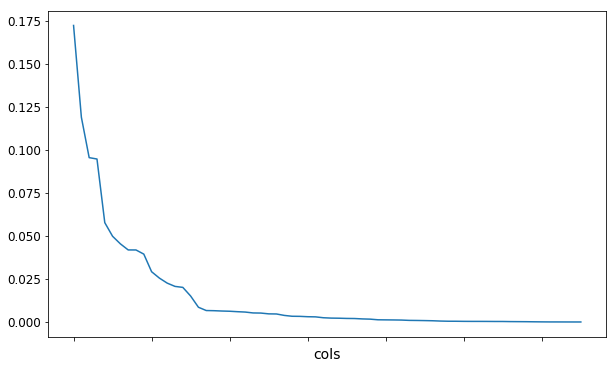

In [13]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [14]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [15]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20776977546429812, 0.2455658589983856, 0.9102120139883698, 0.87321960446416, 0.8943057047544302]


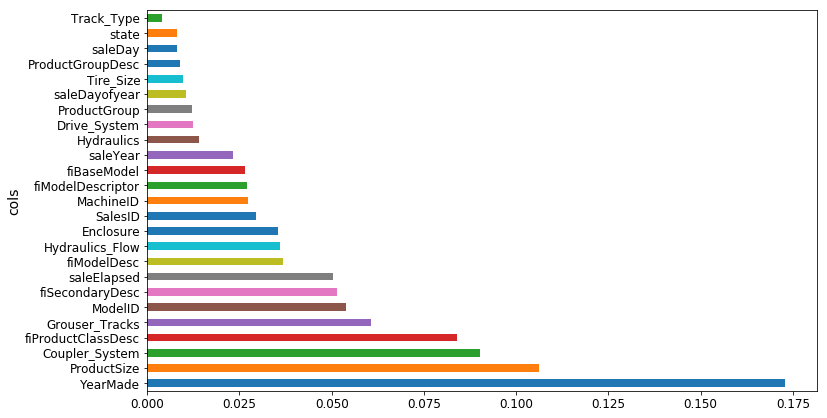

In [16]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

#### One-Hot-Encoding

In [17]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20814835003686322, 0.2506673541770872, 0.9098845128777279, 0.8678973033940733, 0.892597102106593]


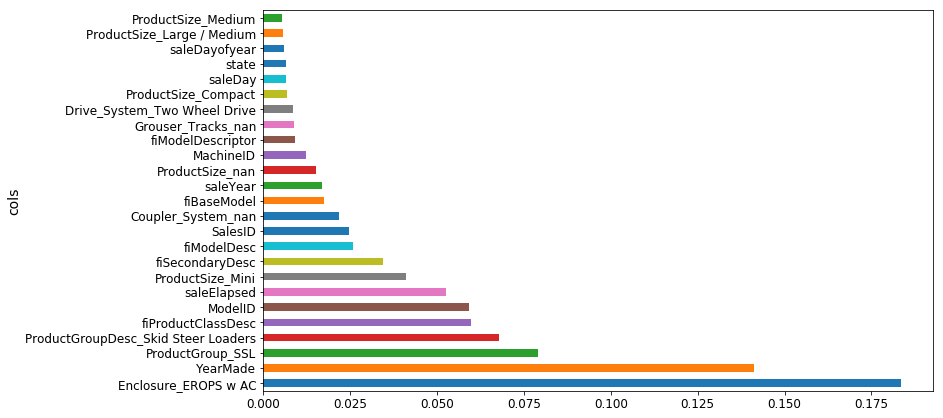

In [18]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

zip - cardinality of 5000 (how many levels)
usabeband - 6 (encode it)
sex - 2 (encode it wiht o-h)

### Removing features

In [19]:
from scipy.cluster import hierarchy as hc

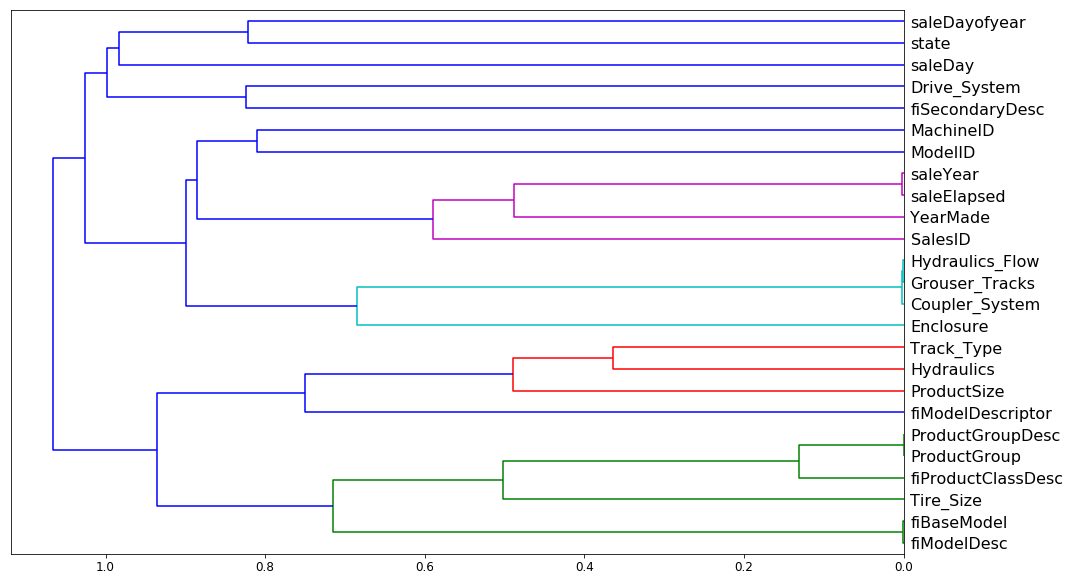

In [20]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Rank Correlation - plot the rank instead of the samples.  
Spearman's R - most famous rank correlation.

In [21]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=8, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [22]:
get_oob(df_keep)

0.890495106115955

In [23]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8893048432054735
saleElapsed 0.8872181541942268
fiModelDesc 0.8894337548272339
fiBaseModel 0.8895669338676643
Grouser_Tracks 0.8908723299692483
Coupler_System 0.890532519960064


In [24]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8890606578340967

In [25]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [27]:
reset_rf_samples()

In [28]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1246374430807998, 0.2252042711147512, 0.9676889886977111, 0.8933724637040455, 0.909750288492831]


### Partial Dependance

In [29]:
from plotnine import *
from pdpbox import pdp

In [30]:
set_rf_samples(50000)

In [31]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

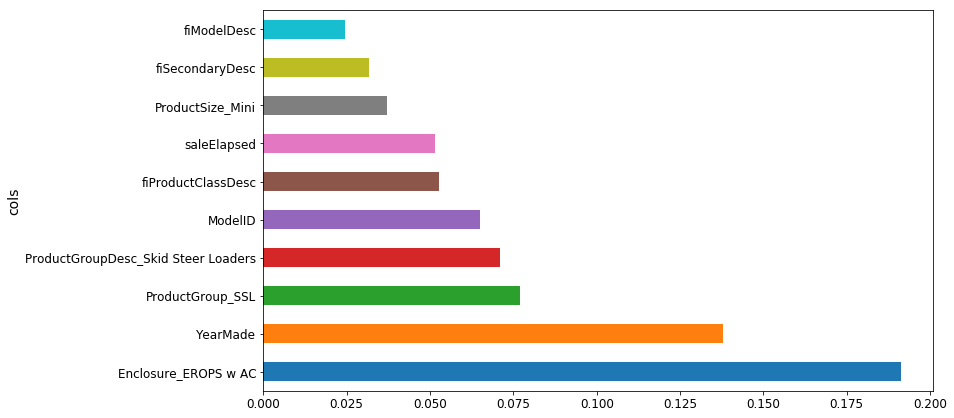

In [32]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

For the important features how they related to the dependant variable.

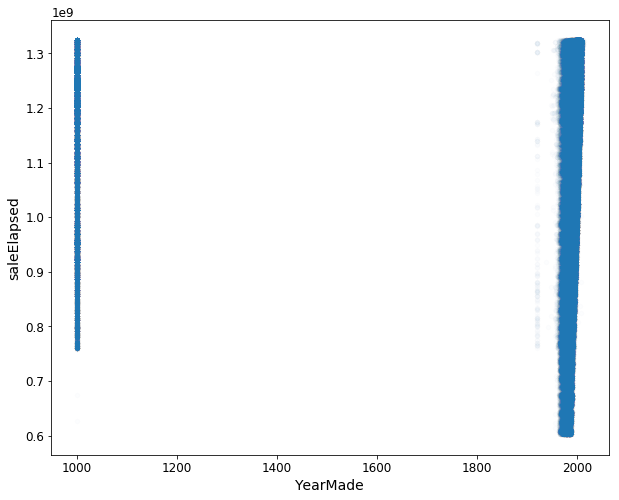

In [33]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [34]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

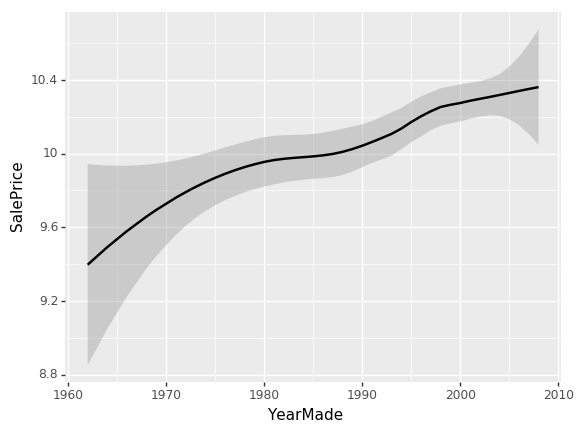

<ggplot: (8783730307048)>

In [35]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')
# se - standard error - adds confidence interval

Plotting things - reduce samples.

In [36]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [37]:
def plot_pdp(feat_name, clusters=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1f1c4dc50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d6c291d0>})

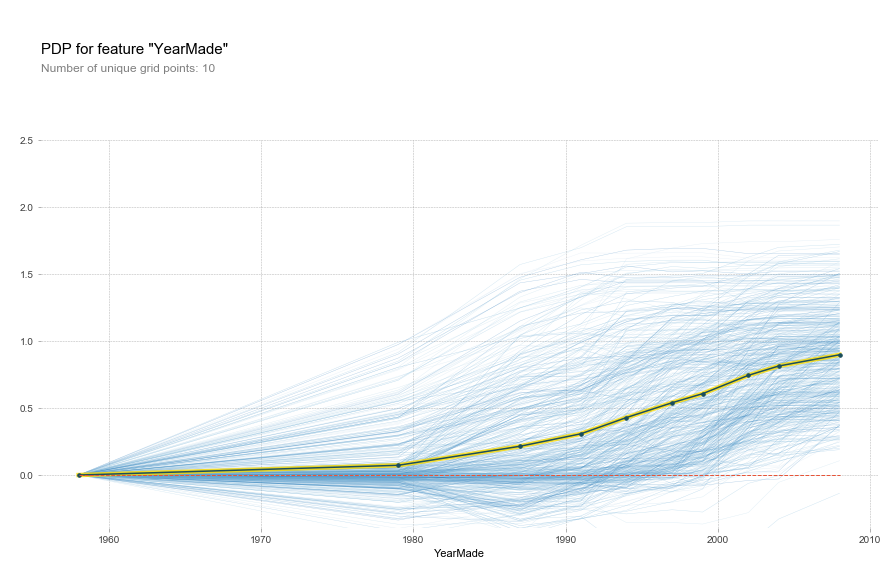

In [38]:
plot_pdp(feat_name='YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d7d33128>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d7c8bb00>})

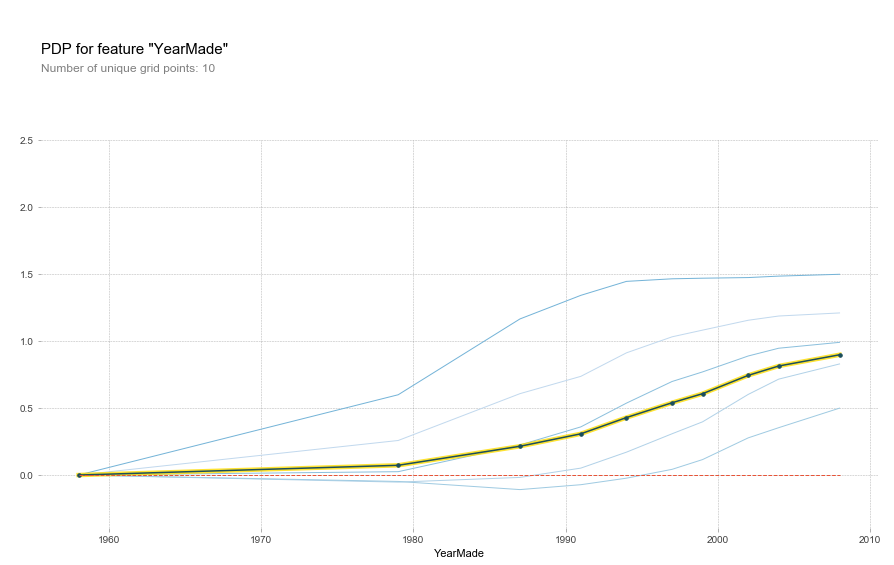

In [39]:
plot_pdp('YearMade', clusters=5)


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d7d457f0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d6c32128>})

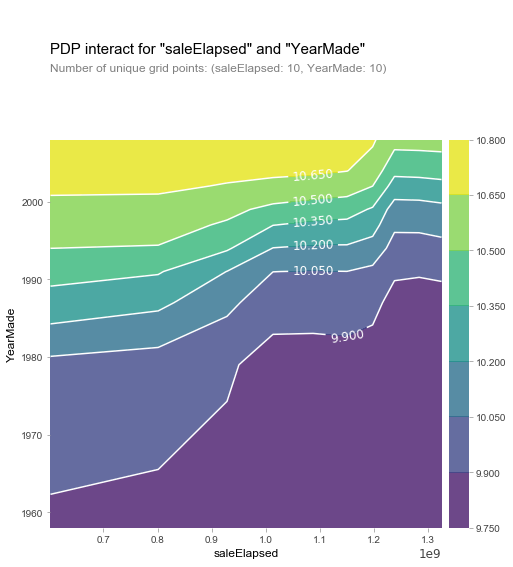

In [40]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, features=feats, model_features=x.columns)
pdp.pdp_interact_plot(p, feats)
## pdp plot updated - refer to the original notebook

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d7cd7f60>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1d7cb13c8>})

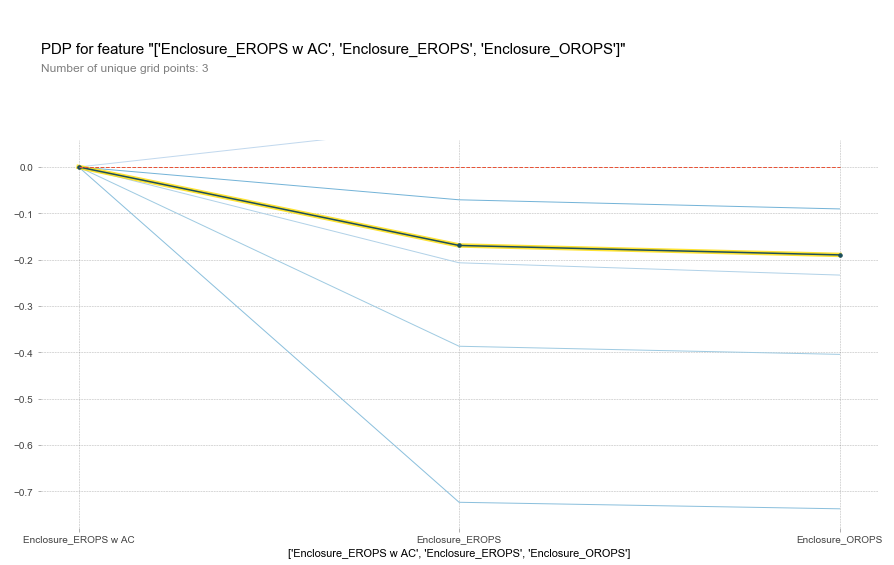

In [41]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], clusters=5)

In [42]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

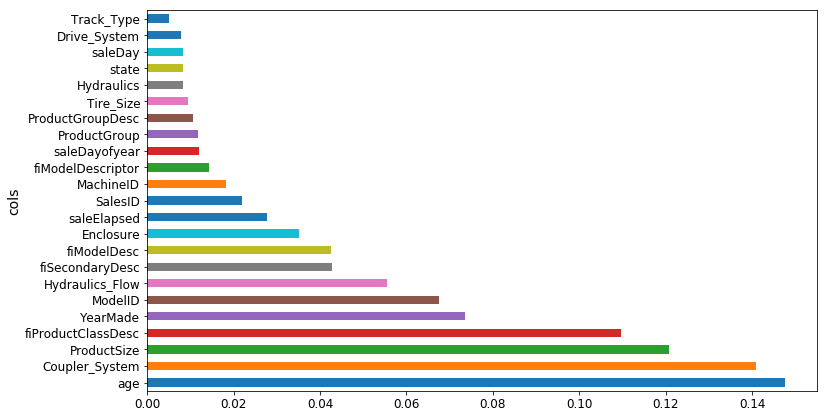

In [43]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

### Tree interpreter

In [44]:
from treeinterpreter import treeinterpreter as ti

In [45]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [46]:
row = X_valid.values[None,0]; row

array([[      2005,          1,         43,          0,      17318, 1324339200,          6,          0,
                 3,       4464,    6311459,          0,    1835718,          0,          0,         20,
                43,        354,          3,          3,          4,          0,          6]])

In [47]:
prediction, bias, contributions = ti.predict(m, row)

In [48]:
prediction[0], bias[0] # bias - the avg. sale price

(array([9.5094]), 10.105111775449933)

In [49]:
idxs = np.argsort(contributions[0])

In [50]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('Coupler_System', 'None or Unspecified', -0.609073413209668),
 ('Hydraulics_Flow', 'Standard', -0.24136911551932805),
 ('age', 6, -0.07069949241952811),
 ('Enclosure', 'OROPS', -0.03745289581710805),
 ('MachineID', 1835718, -0.016295145039666135),
 ('saleDayofyear', 354, -0.01523512238025968),
 ('ProductSize', nan, -0.01166234694467545),
 ('SalesID', 6311459, -0.00921352854907891),
 ('ProductGroup', 'SSL', -0.007791544070294964),
 ('fiSecondaryDesc', nan, -0.007225751641359102),
 ('Hydraulics', 'Auxiliary', -0.0030338801000008965),
 ('state', 'Tennessee', -0.002445263268032605),
 ('ProductGroupDesc', 'Skid Steer Loaders', 0.0),
 ('Tire_Size', nan, 0.0),
 ('fiModelDescriptor', nan, 0.0),
 ('Track_Type', nan, 0.0),
 ('Drive_System', nan, 0.0),
 ('saleDay', 20, 0.004279363248056045),
 ('ModelID', 17318, 0.007036233941852155),
 ('fiModelDesc', 'T250', 0.01239896477177851),
 ('saleElapsed', 1324339200, 0.03566317889710198),
 ('YearMade', 2005, 0.16771149856559536),
 ('fiProductClassDesc',

In [51]:
contributions[0].sum()

-0.5957152223042458

### Extrapolation

In [57]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [58]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=8, oob_score=True)
m.fit(x, y)
m.oob_score_

0.9999950140230601

In [59]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.939439
5,saleElapsed,0.018256
4,ModelID,0.012587
12,MachineID,0.011153
9,fiModelDesc,0.008148
2,fiProductClassDesc,0.002525
8,Hydraulics_Flow,0.002385
11,fiModelDescriptor,0.001570
7,fiSecondaryDesc,0.000954
0,YearMade,0.000936


In [60]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [61]:
(X_train[feats]/1000).describe()


,SalesID,saleElapsed,MachineID
count,399925.000000,3.999250e+05,399925.000000
mean,1906.514076,1.090754e+06,1216.163426
std,877.820942,1.815455e+05,440.318036
min,1139.246000,6.009984e+05,0.000000
25%,1417.915000,9.701856e+05,1088.138000
50%,1638.631000,1.142640e+06,1278.458000
75%,2240.856000,1.237421e+06,1466.601000
max,6311.456000,1.325203e+06,2486.330000


In [62]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,1200.000000,1.200000e+03,1200.000000
mean,6318.369453,1.317818e+06,1797.491160
std,6.363811,4.889874e+03,235.644958
min,6311.459000,1.308701e+06,17.825000
25%,6312.188750,1.313539e+06,1812.613000
50%,6317.843500,1.317686e+06,1854.830500
75%,6320.703250,1.323130e+06,1897.940250
max,6333.342000,1.325203e+06,2484.864000


In [63]:
x.drop(feats, axis=1, inplace=True)

In [64]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9974546587722032

In [65]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
14,saleDayofyear,0.184468
19,age,0.147553
4,ModelID,0.126644
0,YearMade,0.124143
8,fiModelDesc,0.108256
12,saleDay,0.061921
13,state,0.055721
2,fiProductClassDesc,0.037868
1,Coupler_System,0.030432
5,Enclosure,0.023376


In [66]:
set_rf_samples(50000)

In [67]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [68]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=8, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20867210768786762, 0.2506586630036343, 0.909430432332051, 0.8679064638014948, 0.8934180266090339]


In [69]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2098363197721029, 0.2489278343211504, 0.9084170115642306, 0.8697244094893269, 0.8925655732079966]
saleElapsed
[0.21467269186799856, 0.24907968726221683, 0.9041466946151784, 0.8695654175016938, 0.8874304197178187]
MachineID
[0.20707555486656343, 0.24532450612334722, 0.9108110282885805, 0.8734686926408264, 0.8954780203706427]
age
[0.20919355742646192, 0.24741723950969752, 0.9089772190476458, 0.8713007420029868, 0.8928395448606553]
YearMade
[0.20952162890371745, 0.25166637239435824, 0.9086914990248594, 0.8668422319369926, 0.8925125532023386]
saleDayofyear
[0.20913486580745766, 0.24701472598730997, 0.9090282868245727, 0.8717191530519884, 0.89334324800218]


In [70]:
reset_rf_samples()

In [71]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1370979183582083, 0.22073874450662864, 0.9609055407217599, 0.8975591283662181, 0.9101905345590979]


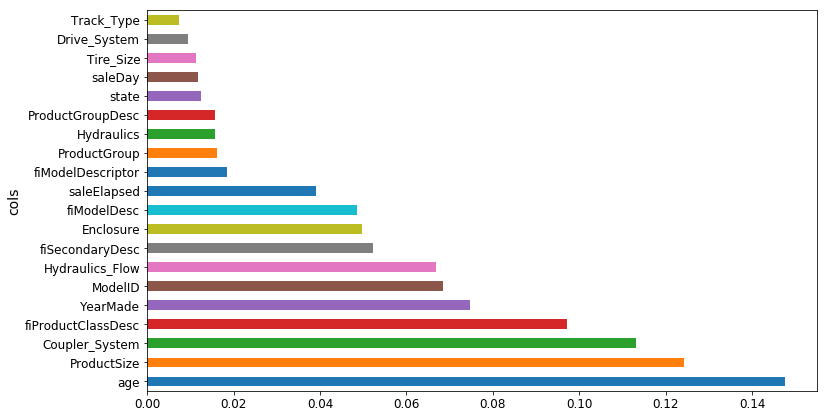

In [72]:
plot_fi(rf_feat_importance(m, X_train));

In [73]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [74]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=8, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 56s, sys: 1.21 s, total: 3min 58s
Wall time: 37 s
[0.0797685645867214, 0.21112114886385794, 0.9867652103367001, 0.9062913653994282, 0.9158553685381773]
